Neural Network for CAP Classification<br>
Author: Apurva R Umredkar<br><br>
Description:<br>
&emsp; Running the model with 10 fold stratified cross validation on the 22k sample dataset



In [1]:
#Libraries
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import *

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#dataset = loadmat("/content/drive/MyDrive/CAP Research Data/eeg _signals_1d_balanced_9306.mat")['val']
dataset= np.load("/content/drive/MyDrive/CAP Research Data/eeg_data_21984_balanced.npy")
N= dataset.shape[0]
mmscaler= MinMaxScaler()

signals= dataset[:,:1024]
signals_dft= np.fft.fft(signals)
dft_abs = np.abs(signals_dft)
dft_ang = np.angle(signals_dft)

inputs = mmscaler.fit_transform(dft_abs[:,1:513]).reshape((N,512,1))
targets= dataset[:,1024]

from sklearn.utils import shuffle
X, Y= shuffle(inputs, targets, random_state= None)

skfold = StratifiedKFold(n_splits=10)

In [3]:
#Architecture of the model
def inception_module(layer, f1, f2, f3, f4):
  conv1 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv2 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  conv3 = Conv1D(f1, 1, activation= 'relu', padding= 'same')(layer)
  maxp = MaxPool1D(pool_size=3, strides= 1, padding= 'same')(layer)

  conv2 = Conv1D(f2, 3, activation= 'relu', padding= 'same')(conv2)
  conv3 = Conv1D(f3, 5, activation= 'relu', padding= 'same')(conv3)
  conv4 = Conv1D(f4, 1, activation= 'relu', padding= 'same')(maxp)

  return Concatenate()([conv1, conv2, conv3, conv4])

input_signal= Input(shape=(512,1))

incept= inception_module(input_signal, 32,64,128,32)
conv= Conv1D(192, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(128, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(128, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,16,32,64,16)
conv= Conv1D(96, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(64, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(64, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,8,16,32,8)
conv= Conv1D(48, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(32, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(32, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,4,8,16,4)
conv= Conv1D(24, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(16, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(16, return_sequences= True)(conv)

maxp= MaxPool1D()(gru)

incept= inception_module(maxp,2,4,8,2)
conv= Conv1D(12, 5, activation= 'relu', padding= 'same')(incept)
conv= Conv1D(8, 3, activation= 'relu', padding= 'same')(conv)
gru= GRU(8, return_sequences= True)(conv)

flat = Flatten()(gru)
output= Dense(2, activation='softmax')(flat)


if 'model' in globals() or 'model' in locals(): del model

model= keras.Model(inputs = input_signal, outputs = output)
model.summary()
init_weights = model.get_weights()
#plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 512, 32)      64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 512, 1)       0           input_1[0][0]                    
______________________________________________________________________________________________

Training for Fold #1
Epoch 1/2500
248/248 [==============================] - 67s 103ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 2/2500
248/248 [==============================] - 22s 88ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 3/2500
248/248 [==============================] - 22s 89ms/step - loss: 0.6862 - accuracy: 0.5437 - val_loss: 0.6640 - val_accuracy: 0.6224
Epoch 4/2500
248/248 [==============================] - 22s 89ms/step - loss: 0.6547 - accuracy: 0.6269 - val_loss: 0.6406 - val_accuracy: 0.6333
Epoch 5/2500
248/248 [==============================] - 22s 89ms/step - loss: 0.6367 - accuracy: 0.6415 - val_loss: 0.6252 - val_accuracy: 0.6548
Epoch 6/2500
248/248 [==============================] - 22s 89ms/step - loss: 0.6260 - accuracy: 0.6523 - val_loss: 0.6147 - val_accuracy: 0.6654
Epoch 7/2500
248/248 [==============================] - 22s 90ms/step - loss: 0.6194 - accuracy: 0.663

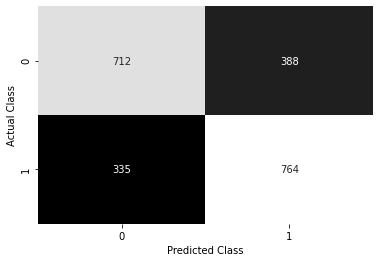

Accuracy Metrics:                0
count  99.000000
mean    0.683244
std     0.035078
min     0.496525
25%     0.675322
50%     0.689727
75%     0.701700
max     0.718979

Loss Metrics:                0
count  99.000000
mean    0.573291
std     0.031267
min     0.532390
25%     0.552972
50%     0.567496
75%     0.585194
max     0.693157

Val. Accuracy Metrics:                0
count  99.000000
mean    0.671325
std     0.026616
min     0.498357
25%     0.671342
50%     0.676775
75%     0.679555
max     0.687137

Val. Loss Metrics:                0
count  99.000000
mean    0.589177
std     0.020298
min     0.575134
25%     0.578993
50%     0.582109
75%     0.591575
max     0.693148


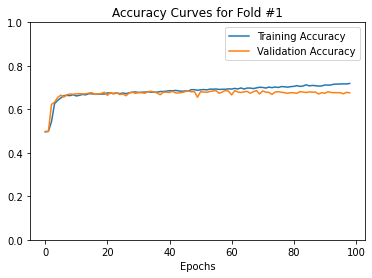

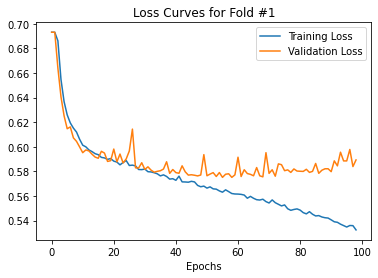

Training for Fold #2
Epoch 1/2500
248/248 [==============================] - 32s 98ms/step - loss: 0.6925 - accuracy: 0.4978 - val_loss: 0.6891 - val_accuracy: 0.4968
Epoch 2/2500
248/248 [==============================] - 22s 91ms/step - loss: 0.6832 - accuracy: 0.5549 - val_loss: 0.6734 - val_accuracy: 0.5936
Epoch 3/2500
248/248 [==============================] - 22s 91ms/step - loss: 0.6681 - accuracy: 0.6207 - val_loss: 0.6635 - val_accuracy: 0.6174
Epoch 4/2500
248/248 [==============================] - 22s 91ms/step - loss: 0.6587 - accuracy: 0.6263 - val_loss: 0.6504 - val_accuracy: 0.6353
Epoch 5/2500
248/248 [==============================] - 22s 90ms/step - loss: 0.6507 - accuracy: 0.6314 - val_loss: 0.6444 - val_accuracy: 0.6419
Epoch 6/2500
248/248 [==============================] - 22s 90ms/step - loss: 0.6447 - accuracy: 0.6329 - val_loss: 0.6396 - val_accuracy: 0.6353
Epoch 7/2500
248/248 [==============================] - 23s 91ms/step - loss: 0.6384 - accuracy: 0.6425

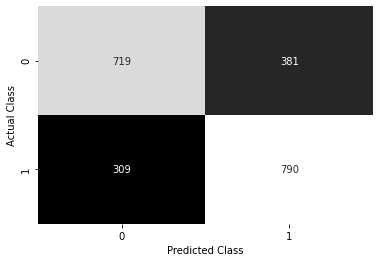

Accuracy Metrics:                 0
count  101.000000
mean     0.683572
std      0.034089
min      0.497789
25%      0.669257
50%      0.682272
75%      0.701857
max      0.744630

Loss Metrics:                 0
count  101.000000
mean     0.577450
std      0.037379
min      0.500779
25%      0.555871
50%      0.577738
75%      0.595106
max      0.692455

Val. Accuracy Metrics:                 0
count  101.000000
mean     0.666364
std      0.021945
min      0.496841
25%      0.662623
50%      0.670963
75%      0.676270
max      0.686379

Val. Loss Metrics:                 0
count  101.000000
mean     0.601366
std      0.020580
min      0.582020
25%      0.586943
50%      0.593637
75%      0.610245
max      0.689136


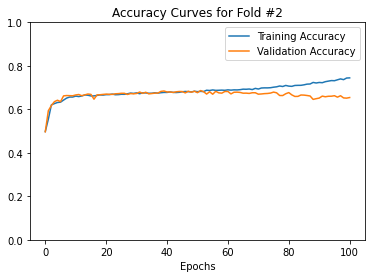

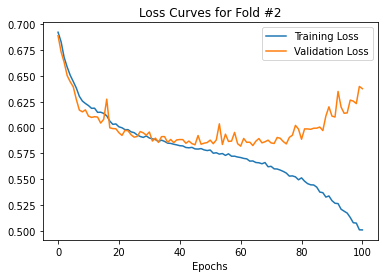

Training for Fold #3
Epoch 1/2500
248/248 [==============================] - 32s 100ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 2/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6928 - accuracy: 0.5031 - val_loss: 0.6913 - val_accuracy: 0.4979
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6848 - accuracy: 0.5285 - val_loss: 0.6744 - val_accuracy: 0.6214
Epoch 4/2500
248/248 [==============================] - 23s 91ms/step - loss: 0.6675 - accuracy: 0.6226 - val_loss: 0.6603 - val_accuracy: 0.6240
Epoch 5/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6599 - accuracy: 0.6298 - val_loss: 0.6552 - val_accuracy: 0.6229
Epoch 6/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6538 - accuracy: 0.6305 - val_loss: 0.6503 - val_accuracy: 0.6333
Epoch 7/2500
248/248 [==============================] - 23s 91ms/step - loss: 0.6485 - accuracy: 0.633

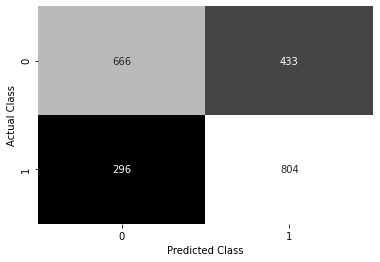

Accuracy Metrics:                 0
count  113.000000
mean     0.687486
std      0.040575
min      0.500442
25%      0.673869
50%      0.687516
75%      0.707165
max      0.756760

Loss Metrics:                 0
count  113.000000
mean     0.570163
std      0.043949
min      0.479546
25%      0.546902
50%      0.569235
75%      0.589638
max      0.693147

Val. Accuracy Metrics:                 0
count  113.000000
mean     0.665220
std      0.025744
min      0.497852
25%      0.663634
50%      0.671468
75%      0.676017
max      0.683851

Val. Loss Metrics:                 0
count  113.000000
mean     0.601367
std      0.024042
min      0.580159
25%      0.585460
50%      0.591178
75%      0.607983
max      0.693134


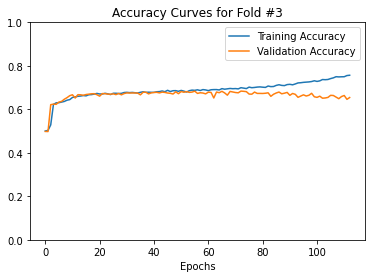

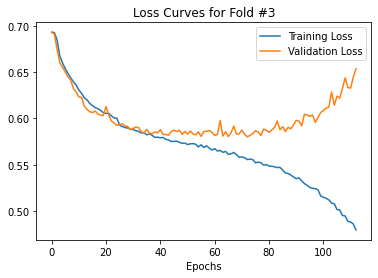

Training for Fold #4
Epoch 1/2500
248/248 [==============================] - 33s 100ms/step - loss: 0.6931 - accuracy: 0.4989 - val_loss: 0.6931 - val_accuracy: 0.4984
Epoch 2/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6930 - accuracy: 0.5348 - val_loss: 0.6928 - val_accuracy: 0.5497
Epoch 3/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6925 - accuracy: 0.5393 - val_loss: 0.6920 - val_accuracy: 0.5706
Epoch 4/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6912 - accuracy: 0.5640 - val_loss: 0.6896 - val_accuracy: 0.6121
Epoch 5/2500
248/248 [==============================] - 23s 91ms/step - loss: 0.6852 - accuracy: 0.6032 - val_loss: 0.6768 - val_accuracy: 0.6189
Epoch 6/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6685 - accuracy: 0.6189 - val_loss: 0.6601 - val_accuracy: 0.6214
Epoch 7/2500
248/248 [==============================] - 23s 92ms/step - loss: 0.6562 - accuracy: 0.623

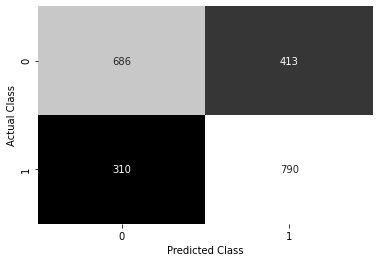

Accuracy Metrics:                 0
count  110.000000
mean     0.686926
std      0.044123
min      0.498863
25%      0.669905
50%      0.687231
75%      0.712772
max      0.763457

Loss Metrics:                 0
count  110.000000
mean     0.573293
std      0.048008
min      0.475394
25%      0.543903
50%      0.572937
75%      0.597160
max      0.693143

Val. Accuracy Metrics:                 0
count  110.000000
mean     0.664335
std      0.025361
min      0.498357
25%      0.662750
50%      0.670205
75%      0.676965
max      0.686884

Val. Loss Metrics:                 0
count  110.000000
mean     0.605061
std      0.027756
min      0.578633
25%      0.584364
50%      0.595569
75%      0.616328
max      0.693103


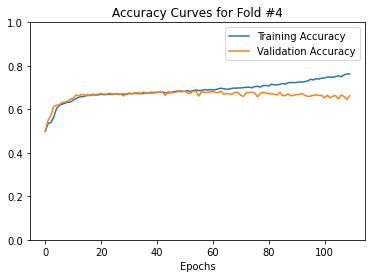

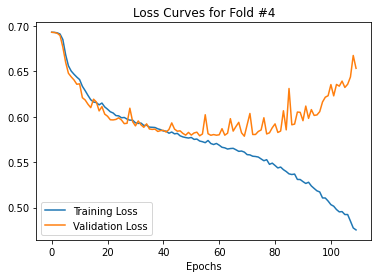

Training for Fold #5
Epoch 1/2500
248/248 [==============================] - 35s 105ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 2/2500
248/248 [==============================] - 24s 95ms/step - loss: 0.6932 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 4/2500
248/248 [==============================] - 23s 95ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 5/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 6/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.5045 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 7/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.509

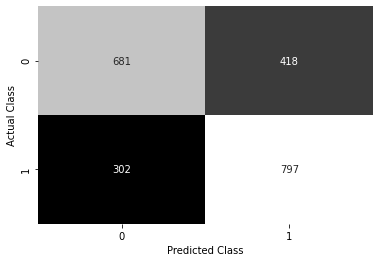

Accuracy Metrics:                 0
count  104.000000
mean     0.671743
std      0.055036
min      0.492861
25%      0.668941
50%      0.683725
75%      0.700025
max      0.733321

Loss Metrics:                 0
count  104.000000
mean     0.584133
std      0.045620
min      0.512836
25%      0.553667
50%      0.576796
75%      0.601292
max      0.693157

Val. Accuracy Metrics:                 0
count  104.000000
mean     0.653394
std      0.048442
min      0.498231
25%      0.662329
50%      0.667383
75%      0.673636
max      0.681405

Val. Loss Metrics:                 0
count  104.000000
mean     0.606325
std      0.030042
min      0.582153
25%      0.587623
50%      0.594991
75%      0.609838
max      0.693148


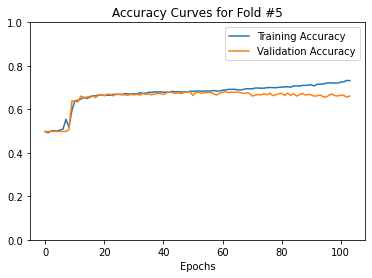

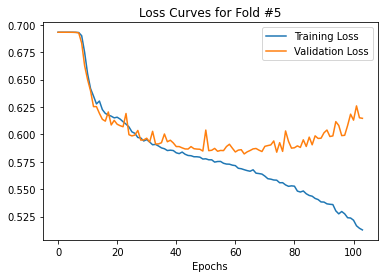

Training for Fold #6
Epoch 1/2500
248/248 [==============================] - 33s 103ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 2/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6932 - accuracy: 0.4926 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5027 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 4/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 5/2500
248/248 [==============================] - 24s 95ms/step - loss: 0.6931 - accuracy: 0.5109 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 6/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5037 - val_loss: 0.6930 - val_accuracy: 0.4995
Epoch 7/2500
248/248 [==============================] - 23s 95ms/step - loss: 0.6924 - accuracy: 0.538

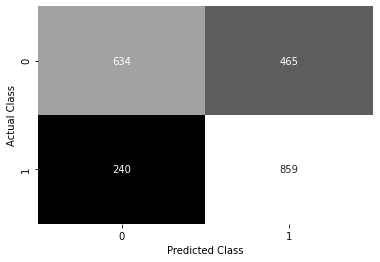

Accuracy Metrics:                 0
count  108.000000
mean     0.674816
std      0.052584
min      0.492608
25%      0.669336
50%      0.680819
75%      0.704227
max      0.742671

Loss Metrics:                 0
count  108.000000
mean     0.580653
std      0.047137
min      0.498370
25%      0.548794
50%      0.577640
75%      0.600692
max      0.693154

Val. Accuracy Metrics:                 0
count  108.000000
mean     0.657597
std      0.043759
min      0.495705
25%      0.664919
50%      0.670667
75%      0.675404
max      0.682163

Val. Loss Metrics:                 0
count  108.000000
mean     0.606534
std      0.028999
min      0.580956
25%      0.587233
50%      0.596390
75%      0.612315
max      0.693147


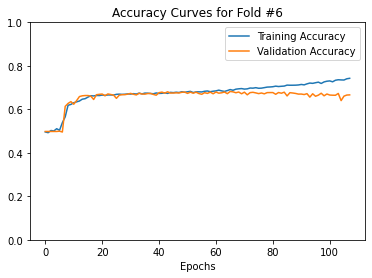

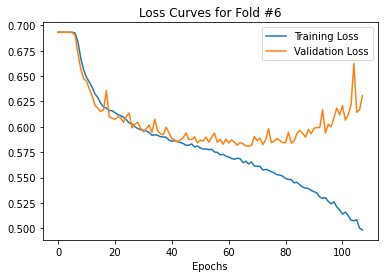

Training for Fold #7
Epoch 1/2500
248/248 [==============================] - 33s 100ms/step - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 2/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 3/2500
248/248 [==============================] - 24s 96ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 4/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 5/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.5090 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 6/2500
248/248 [==============================] - 23s 95ms/step - loss: 0.6931 - accuracy: 0.5184 - val_loss: 0.6930 - val_accuracy: 0.4982
Epoch 7/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6929 - accuracy: 0.504

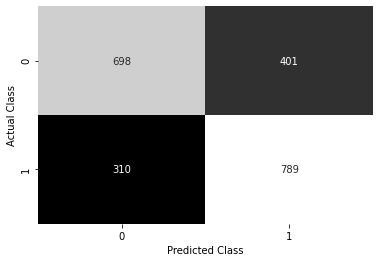

Accuracy Metrics:                 0
count  103.000000
mean     0.666785
std      0.050201
min      0.493808
25%      0.668246
50%      0.678987
75%      0.691559
max      0.717210

Loss Metrics:                 0
count  103.000000
mean     0.591808
std      0.040337
min      0.533909
25%      0.565875
50%      0.581727
75%      0.610540
max      0.693163

Val. Accuracy Metrics:                 0
count  103.000000
mean     0.659561
std      0.047280
min      0.498231
25%      0.666877
50%      0.675341
75%      0.679636
max      0.685447

Val. Loss Metrics:                 0
count  103.000000
mean     0.603613
std      0.030615
min      0.580545
25%      0.585017
50%      0.591318
75%      0.606766
max      0.693147


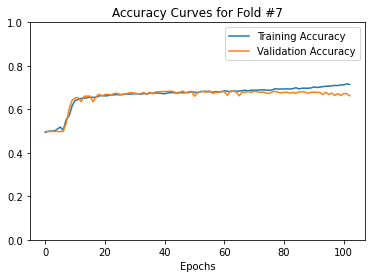

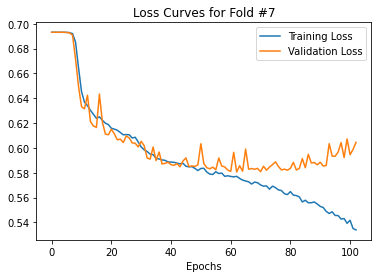

Training for Fold #8
Epoch 1/2500
248/248 [==============================] - 33s 100ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 2/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 4/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.4982
Epoch 5/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6930 - accuracy: 0.5251 - val_loss: 0.6930 - val_accuracy: 0.4982
Epoch 6/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6929 - val_accuracy: 0.4982
Epoch 7/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6928 - accuracy: 0.547

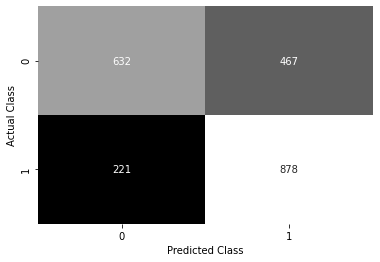

Accuracy Metrics:                 0
count  123.000000
mean     0.678976
std      0.048521
min      0.499874
25%      0.672226
50%      0.684862
75%      0.702963
max      0.743556

Loss Metrics:                 0
count  123.000000
mean     0.579121
std      0.043864
min      0.503093
25%      0.552417
50%      0.574862
75%      0.595931
max      0.693151

Val. Accuracy Metrics:                 0
count  123.000000
mean     0.658013
std      0.042281
min      0.498231
25%      0.664351
50%      0.670288
75%      0.674836
max      0.683426

Val. Loss Metrics:                 0
count  123.000000
mean     0.604131
std      0.027756
min      0.581493
25%      0.587651
50%      0.594360
75%      0.606669
max      0.693143


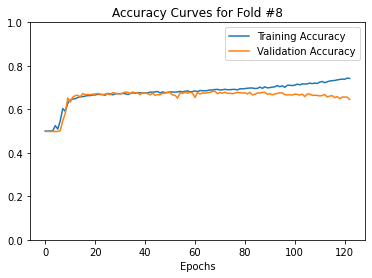

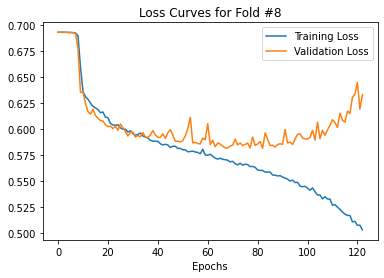

Training for Fold #9
Epoch 1/2500
248/248 [==============================] - 32s 100ms/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 2/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 4/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6931 - accuracy: 0.5024 - val_loss: 0.6931 - val_accuracy: 0.4904
Epoch 5/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6929 - accuracy: 0.5024 - val_loss: 0.6927 - val_accuracy: 0.4904
Epoch 6/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6922 - accuracy: 0.5495 - val_loss: 0.6917 - val_accuracy: 0.5902
Epoch 7/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6901 - accuracy: 0.595

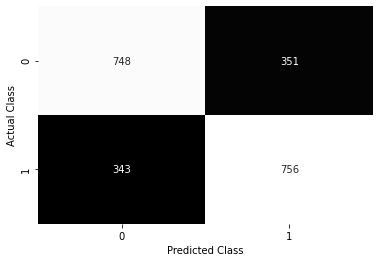

Accuracy Metrics:                0
count  98.000000
mean    0.675361
std     0.050815
min     0.501832
25%     0.668894
50%     0.683883
75%     0.701352
max     0.745514

Loss Metrics:                0
count  98.000000
mean    0.581502
std     0.045209
min     0.498904
25%     0.554767
50%     0.576724
75%     0.596363
max     0.693154

Val. Accuracy Metrics:                0
count  98.000000
mean    0.649779
std     0.040519
min     0.490399
25%     0.654181
50%     0.662077
75%     0.667698
max     0.674836

Val. Loss Metrics:                0
count  98.000000
mean    0.612072
std     0.028646
min     0.587040
25%     0.593217
50%     0.601088
75%     0.617220
max     0.693182


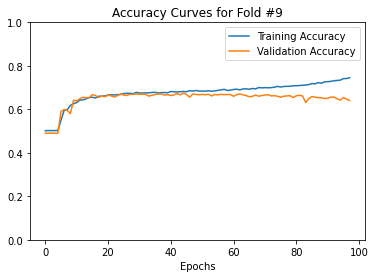

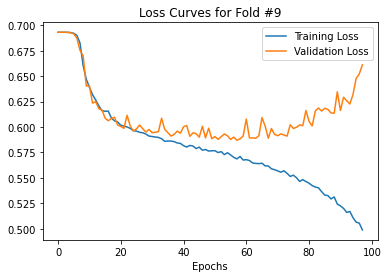

Training for Fold #10
Epoch 1/2500
248/248 [==============================] - 33s 101ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6932 - val_accuracy: 0.4904
Epoch 2/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6924 - accuracy: 0.5053 - val_loss: 0.6866 - val_accuracy: 0.4901
Epoch 3/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6728 - accuracy: 0.5995 - val_loss: 0.6608 - val_accuracy: 0.6337
Epoch 4/2500
248/248 [==============================] - 23s 95ms/step - loss: 0.6594 - accuracy: 0.6275 - val_loss: 0.6484 - val_accuracy: 0.6407
Epoch 5/2500
248/248 [==============================] - 23s 93ms/step - loss: 0.6498 - accuracy: 0.6333 - val_loss: 0.6321 - val_accuracy: 0.6594
Epoch 6/2500
248/248 [==============================] - 23s 94ms/step - loss: 0.6387 - accuracy: 0.6438 - val_loss: 0.6206 - val_accuracy: 0.6657
Epoch 7/2500
248/248 [==============================] - 23s 95ms/step - loss: 0.6343 - accuracy: 0.64

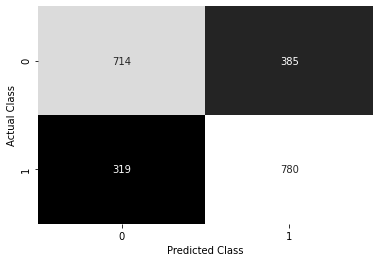

Accuracy Metrics:                 0
count  111.000000
mean     0.684939
std      0.036343
min      0.496525
25%      0.672542
50%      0.686000
75%      0.701415
max      0.752401

Loss Metrics:                 0
count  111.000000
mean     0.570478
std      0.040809
min      0.483389
25%      0.548842
50%      0.570344
75%      0.590041
max      0.693159

Val. Accuracy Metrics:                 0
count  111.000000
mean     0.670481
std      0.026789
min      0.490147
25%      0.665740
50%      0.676604
75%      0.681657
max      0.689995

Val. Loss Metrics:                 0
count  111.000000
mean     0.594231
std      0.023900
min      0.568950
25%      0.577465
50%      0.585324
75%      0.608214
max      0.693178


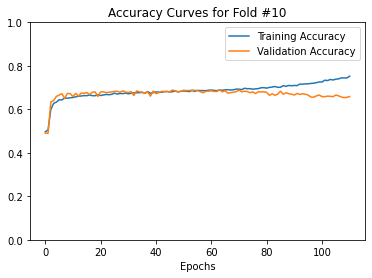

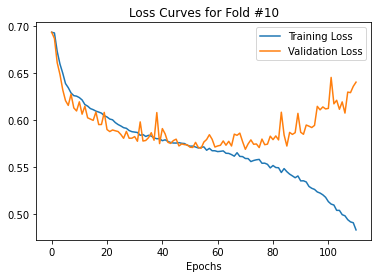

In [4]:
#Hyperparameters
epochs= 2500
batch_size= 64
validation_split= 0.2
lr = 1e-4
early_stop= keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose =1, patience=40, restore_best_weights=True)
opt= keras.optimizers.Adam(learning_rate=lr)

total_confmat = np.zeros((2,2))
fold_num=1
total_history = []
total_results = []

start = time.time()
for train, test in skfold.split(X,Y):
  X_train, X_test = X[train], X[test]
  Y_train =  to_categorical(Y[train])                                                        
  Y_test =  to_categorical(Y[test])                                                        
  
  keras.backend.clear_session()
  model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
  model.set_weights(init_weights)
  model.reset_states()

  print(f'Training for Fold #{fold_num}')
  history = model.fit(X_train, Y_train, validation_split= validation_split, epochs =epochs, batch_size=batch_size, verbose =1, callbacks=[early_stop])
  res = model.evaluate(X_test, Y_test)

  total_history.append(history)
  total_results.append(res)

  #Prediction
  Ypred = model.predict(X_test)
  Ypred = np.round(Ypred)
  print(classification_report(Y_test,Ypred))

  #Confusion Matrix
  confmat = confusion_matrix(Y_test.argmax(axis=1),Ypred.argmax(axis=1))
  confmat_heatmap = sns.heatmap(confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

  total_confmat+= confmat

  #Stats of Metrics
  acc = pd.DataFrame(history.history['accuracy'])
  loss  = pd.DataFrame(history.history['loss'])
  valacc = pd.DataFrame(history.history['val_accuracy'])
  valloss = pd.DataFrame(history.history['val_loss'])
  print(f'Accuracy Metrics: {acc.describe()}\n')
  print(f'Loss Metrics: {loss.describe()}\n')
  print(f'Val. Accuracy Metrics: {valacc.describe()}\n')
  print(f'Val. Loss Metrics: {valloss.describe()}')

  #Plots
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training Accuracy','Validation Accuracy'])
  plt.xlabel('Epochs')
  plt.title(label=f'Accuracy Curves for Fold #{fold_num}')
  plt.ylim(0,1)
  plt.show()
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epochs')
  plt.title(label=f'Loss Curves for Fold #{fold_num}')
  plt.show()

  fold_num+=1

end = time.time()

In [5]:
np.mean(np.array(total_results)[:,1]), np.std(np.array(total_results)[:,1])

(0.6776297926902771, 0.006375635962391478)

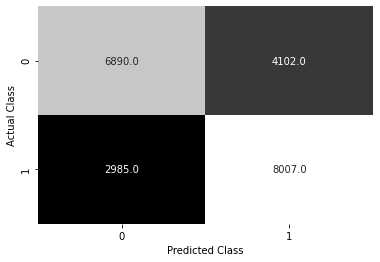

In [6]:
  confmat_heatmap = sns.heatmap(total_confmat, annot=True, fmt='', cmap='gray', cbar = False)
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.title('')
  plt.show()

In [7]:
total_results

[[0.5819836854934692, 0.6712141633033752],
 [0.5759744644165039, 0.6862210035324097],
 [0.5964906215667725, 0.668485701084137],
 [0.5772741436958313, 0.6712141633033752],
 [0.5933542251586914, 0.6724295020103455],
 [0.5868858695030212, 0.679253876209259],
 [0.5878422260284424, 0.6765241026878357],
 [0.5836960077285767, 0.6869881749153137],
 [0.569126307964325, 0.6842584013938904],
 [0.5854503512382507, 0.6797088384628296]]